In [1]:
from PIL import Image
import imageio
import numpy as np
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import torch.nn.functional as F

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils.io import load_from_json

from reni.model_components.illumination_samplers import EquirectangularSamplerConfig
from reni.model_components.shaders import LambertianShader, BlinnPhongShader
from reni.utils.colourspace import linear_to_sRGB

normals_path = '/workspace/data/RENI_HDR/3d_models/teapot_normals.exr'
normals = imageio.v2.imread(normals_path)
normals = torch.tensor(normals).float()
normals = F.interpolate(normals.unsqueeze(0).permute(0, 3, 1, 2), size=(128, 128), mode='nearest').squeeze(0).permute(1, 2, 0)
# normalise normals where the magnitude is greater than 0
norms = torch.norm(normals, dim=-1, keepdim=True)
mask = norms.squeeze(-1) > 0
normals[mask] = normals[mask] / norms[mask]
# invert y axis of normals 
normals[:, :, 1] = -normals[:, :, 1]

image_height, image_width = normals.shape[:2]

transforms_path = Path('/workspace/data/RENI_HDR/3d_models/bunny_cam_transforms.json')
meta = load_from_json(transforms_path)
poses = []
for frame in meta["frames"]:
    poses.append(np.array(frame["transform_matrix"]))
poses = np.array(poses).astype(np.float32)
camera_angle_x = float(meta["camera_angle_x"])
focal_length = 0.5 * image_width / np.tan(0.5 * camera_angle_x)
cx = image_width / 2.0
cy = image_height / 2.0
camera_to_world = torch.from_numpy(poses[:, :3])  # camera to world transform
cameras = Cameras(
    camera_to_worlds=camera_to_world,
    fx=focal_length,
    fy=focal_length,
    cx=cx,
    cy=cy,
    camera_type=CameraType.PERSPECTIVE,
)
camera_rays = cameras.generate_rays(0)

environment_map_path = '/workspace/data/RENI_HDR/val/00001.exr' 
environment_map = imageio.v2.imread(environment_map_path)
env_map_image_height, env_map_image_width = environment_map.shape[:2] # 64x128
environment_map = torch.tensor(environment_map).reshape(-1, 3).float()

ray_sampler_config = EquirectangularSamplerConfig(width=env_map_image_width, apply_random_rotation=False, remove_lower_hemisphere=False)
ray_sampler = ray_sampler_config.setup()
illumination_samples = ray_sampler.generate_direction_samples()

lambertian_shader = LambertianShader()
blinn_phong_shader = BlinnPhongShader()

In [4]:
# get everything into correct sizes
normals = normals.reshape(-1, 3) # N x 3
mask = ~(torch.norm(normals, dim=-1) > 0)
specular = torch.ones_like(normals) * 0.7 # N x 3
albedo = 1 - specular
albedo[mask] = 0
specular[mask] = 0
shiniess = torch.ones_like(normals[:, 0]).squeeze() * 500.0 # N
shiniess[mask] = 0
view_directions = camera_rays.directions.reshape(-1, 3) # N x 3

light_directions = illumination_samples.frustums.directions.unsqueeze(0).repeat(normals.shape[0], 1, 1) # N x M x 3
# ensure light directions are normalized
light_directions = light_directions / torch.norm(light_directions, dim=-1, keepdim=True)
light_colours = environment_map.unsqueeze(0).repeat(normals.shape[0], 1, 1) # N x M x 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


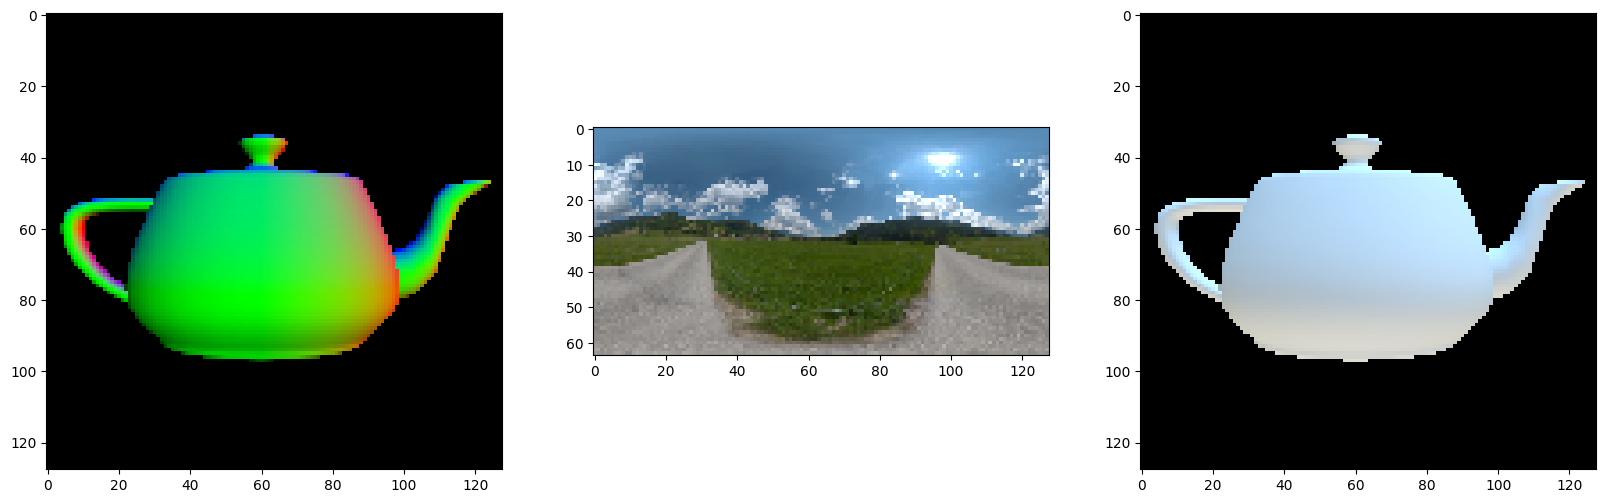

In [3]:
lambertian_color_sum, shaded_albedo = lambertian_shader(albedo=albedo,
                                                        normals=normals,
                                                        light_directions=light_directions,
                                                        light_colors=light_colours)

shaded_albedo = shaded_albedo.reshape(image_height, image_width, 3)
shaded_albedo = linear_to_sRGB(shaded_albedo, use_quantile=True)
normals = normals.reshape(image_height, image_width, 3)
environment_map_ldr = linear_to_sRGB(environment_map.reshape(env_map_image_height, env_map_image_width, 3))
# plot all
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(normals)
ax[1].imshow(environment_map_ldr)
ax[2].imshow(shaded_albedo)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


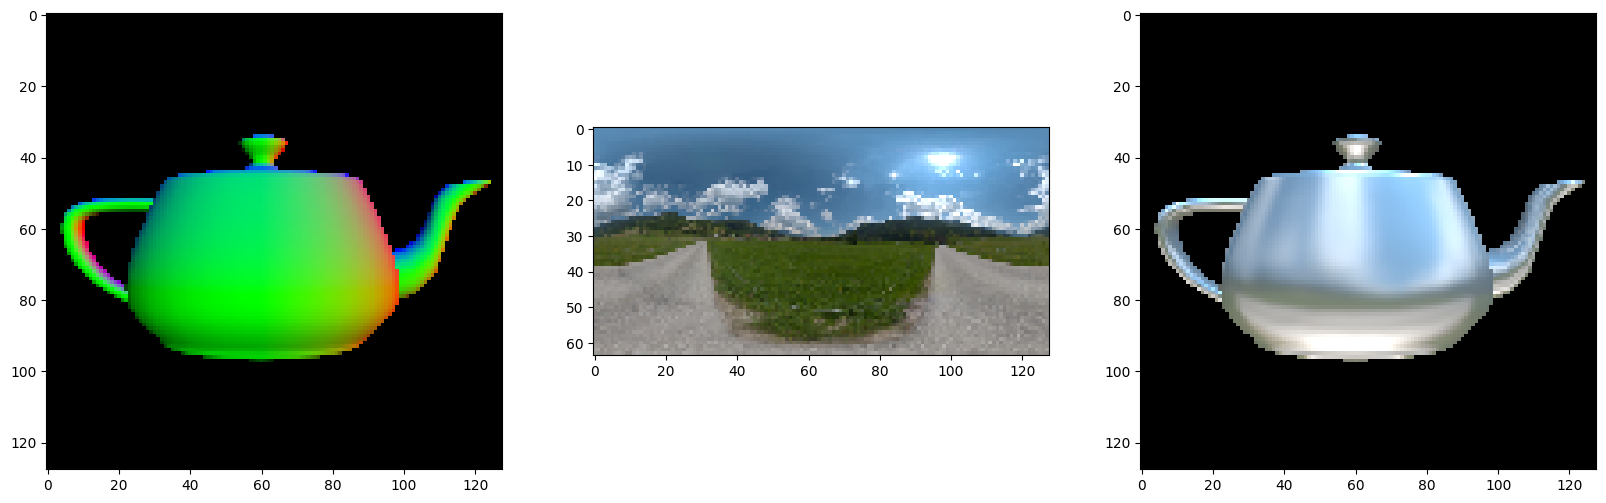

In [5]:
blinn_phong_color_sum, shaded_albedo = blinn_phong_shader(albedo=albedo,
                                              normals=normals,
                                              light_directions=light_directions,
                                              light_colors=light_colours,
                                              specular=specular,
                                              shininess=shiniess,
                                              view_directions=view_directions,
                                              detach_normals=True)

shaded_albedo = shaded_albedo.reshape(image_height, image_width, 3)
shaded_albedo = linear_to_sRGB(shaded_albedo, use_quantile=True)
normals = normals.reshape(image_height, image_width, 3)
environment_map_ldr = linear_to_sRGB(environment_map.reshape(env_map_image_height, env_map_image_width, 3))
# plot all
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(normals)
ax[1].imshow(environment_map_ldr)
ax[2].imshow(shaded_albedo)
plt.show()

In [ ]:
from reni.data.dataparsers.reni_inverse_dataparser import RENIInverseDataParserConfig
from reni.data.datasets.reni_inverse_dataset import RENIInverseDataset